In [1]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

In [11]:
df = pd.read_csv('data_preprocessed.csv')

In [12]:
df

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0,40,USA,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0,13,USA,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0,40,USA,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0,40,USA,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0,40,other,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0,36,USA,<=50K
48838,64,NaN,321403,HS-grad,Widowed,NaN,Other-relative,Black,Male,0.0,0,40,USA,<=50K
48839,38,Private,374983,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0,50,USA,<=50K
48840,44,Private,83891,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0,40,USA,<=50K


In [13]:
df['income'].apply(lambda x: 1 if x=='>50K' else 0)

0        0
1        0
2        0
3        0
4        0
        ..
48837    0
48838    0
48839    0
48840    0
48841    1
Name: income, Length: 48842, dtype: int64

In [20]:
df = pd.read_csv('data_preprocessed.csv')
df = pd.get_dummies(df, drop_first=True)
df

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-country_other,income_>50K
0,39,77516,2174.0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,50,83311,0.0,0,13,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
2,38,215646,0.0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
3,53,234721,0.0,0,40,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,28,338409,0.0,0,40,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,0.0,0,36,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
48838,64,321403,0.0,0,40,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
48839,38,374983,0.0,0,50,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
48840,44,83891,5455.0,0,40,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0


In [21]:
df.columns

Index(['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week',
       'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate',
       'education_HS-grad', 'education_Masters', 'education_Preschool',
       'education_Prof-school', 'education_Some-college',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Hand

In [8]:
df = pd.read_csv('data_preprocessed.csv')
scaler = MinMaxScaler()

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
pd.get_dummies(df, drop_first=True)

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-country_other,income_>50K
0,0.301370,0.044131,0.052626,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0.452055,0.048052,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
2,0.287671,0.137581,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
3,0.493151,0.150486,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0.150685,0.220635,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.301370,0.137428,0.000000,0.0,0.357143,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
48838,0.643836,0.209130,0.000000,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
48839,0.287671,0.245379,0.000000,0.0,0.500000,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
48840,0.369863,0.048444,0.132050,0.0,0.397959,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0


c:\Users\kaami\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\kaami\anaconda3\lib\site-

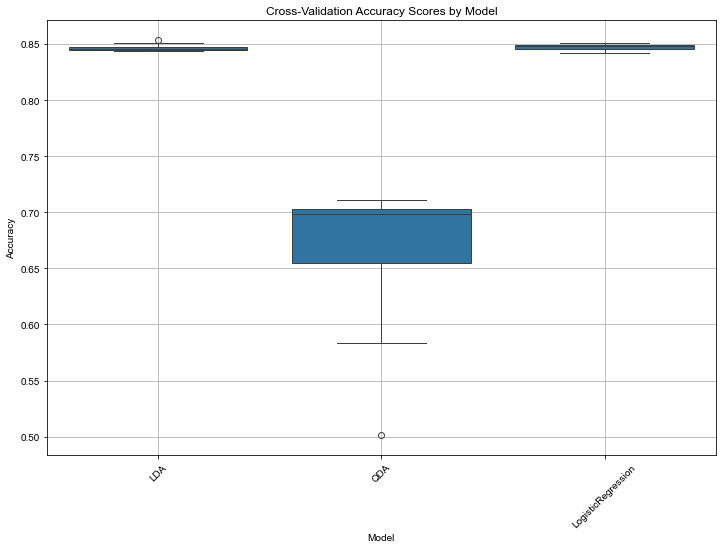

In [7]:
def preprocess_data(df, drop_columns=[]):
    df = df.dropna()
    scaler = MinMaxScaler()

    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    df = pd.get_dummies(df, drop_first=True)
    df = df.drop(columns=drop_columns)
    return df

def train_and_evaluate_models(X_train, y_train, X_test, y_test, model_params):
    results = {}
    for name, model, params in model_params:
        clf = GridSearchCV(model, params, cv=5)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        cm_train = confusion_matrix(y_train, y_pred_train)
        cm_test = confusion_matrix(y_test, y_pred_test)
        results[name] = {'model': clf.best_estimator_, 'cm_train': cm_train, 'cm_test': cm_test}
    return results

def perform_cross_validation(model_list, X, y):
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    scores_data = []
    
    for name, model in model_list:
        scores = cross_val_score(model, X, y, cv=rskf, scoring='accuracy')
        for score in scores:
            scores_data.append({'Model': name, 'Accuracy': score})
    
    # Create DataFrame for visualization
    scores_df = pd.DataFrame(scores_data)
    
    # Plotting
    plt.figure(figsize=(12, 8))  # Wider figure for clarity
    sns.boxplot(x='Model', y='Accuracy', data=scores_df)
    plt.title('Cross-Validation Accuracy Scores by Model')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.grid(True)  # Add grid for better readability of scales
    sns.set_style("whitegrid")  # Set the style of the visualization
    plt.show()

# Main execution
df = pd.read_csv('data_preprocessed.csv')
df = df.dropna()
X = preprocess_data(df, drop_columns=['income_>50K'])
y = df['income'].apply(lambda x: 1 if x=='>50K' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = [
    ('LDA', LinearDiscriminantAnalysis(), {}),
    ('QDA', QuadraticDiscriminantAnalysis(), {}),
    ('LogisticRegression', LogisticRegression(), {'C': [0.1, 1, 10]}),
    # Add other models and parameters similarly
]

trained_models = train_and_evaluate_models(X_train, y_train, X_test, y_test, models)
cv_results = perform_cross_validation([(name, mod['model']) for name, mod in trained_models.items()], X, y)


In [13]:
from sklearn.metrics import accuracy_score, f1_score

def extract_metrics_from_cm(results):
    metrics = {}
    for name, result in results.items():
        tn_train, fp_train, fn_train, tp_train = result['cm_train'].ravel()
        tn_test, fp_test, fn_test, tp_test = result['cm_test'].ravel()

        # Compute accuracy and F1 score from confusion matrix
        accuracy_train = (tp_train+tn_train)/(tn_train + fp_train + fn_train + tp_train)
        accuracy_test = (tp_test+tn_test)/(tn_test + fp_test + fn_test + tp_test)
        
        f1_train = 2*tp_train/(2*tp_train+fp_train+fn_train)
        f1_test = 2*tp_test/(2*tp_test+fp_test+fn_test)

        metrics[name] = {
            'accuracy_train': accuracy_train,
            'accuracy_test': accuracy_test,
            'f1_train': f1_train,
            'f1_test': f1_test
        }
    return metrics

import matplotlib.pyplot as plt
import numpy as np

def plot_model_performance(metrics):
    labels = list(metrics.keys())
    accuracy_train = [m['accuracy_train'] for m in metrics.values()]
    accuracy_test = [m['accuracy_test'] for m in metrics.values()]
    f1_train = [m['f1_train'] for m in metrics.values()]
    f1_test = [m['f1_test'] for m in metrics.values()]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # narrower bars for better separation

    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - 1.5*width, accuracy_train, width, label='Accuracy (Train)')
    rects2 = ax.bar(x - 0.5*width, accuracy_test, width, label='Accuracy (Test)')
    rects3 = ax.bar(x + 0.7*width, f1_train, width, label='F1 Score (Train)')
    rects4 = ax.bar(x + 1.7*width, f1_test, width, label='F1 Score (Test)')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Model')
    ax.set_title('Model Performance: Accuracy and F1 Score')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')
    ax.bar_label(rects3, padding=3, fmt='%.2f')
    ax.bar_label(rects4, padding=3, fmt='%.2f')

    plt.show()




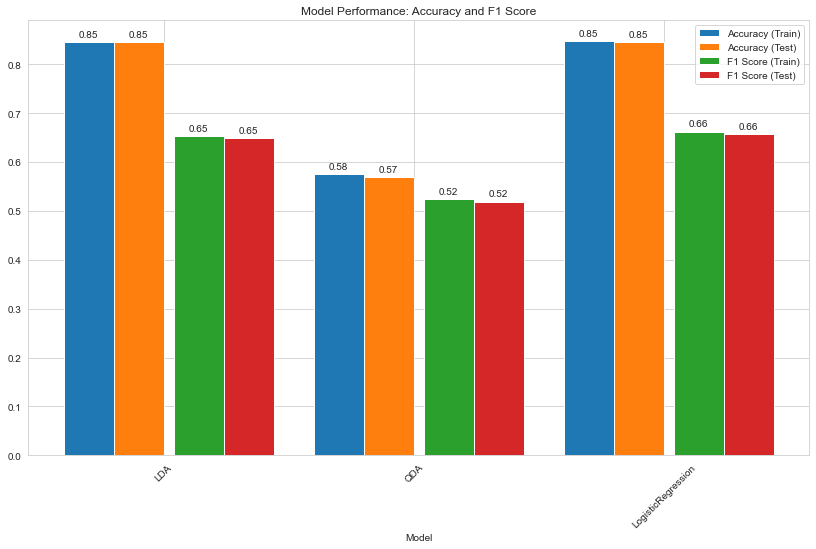

In [14]:
model_metrics = extract_metrics_from_cm(trained_models)
plot_model_performance(model_metrics)

In [15]:
from sklearn.metrics import precision_score, recall_score

def extract_precision_recall_from_cm(results):
    metrics = {}
    for name, result in results.items():
        tn_train, fp_train, fn_train, tp_train = result['cm_train'].ravel()
        tn_test, fp_test, fn_test, tp_test = result['cm_test'].ravel()

        # Compute precision and recall from confusion matrix
        precision_train = tp_train/(tp_train+fp_train)
        recall_train = tp_train/(tp_train+fn_train)
        
        precision_test = tp_test/(tp_test+fp_test)
        recall_test = tp_test/(tp_test+fn_test)

        metrics[name] = {
            'precision_train': precision_train,
            'precision_test': precision_test,
            'recall_train': recall_train,
            'recall_test': recall_test
        }
    return metrics


def plot_precision_recall_performance(metrics):
    labels = list(metrics.keys())
    precision_train = [m['precision_train'] for m in metrics.values()]
    precision_test = [m['precision_test'] for m in metrics.values()]
    recall_train = [m['recall_train'] for m in metrics.values()]
    recall_test = [m['recall_test'] for m in metrics.values()]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # narrower bars for better separation

    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - 1.5*width, precision_train, width, label='Precision (Train)', color='blue')
    rects2 = ax.bar(x - 0.5*width, precision_test, width, label='Precision (Test)', color='orange')
    # Add space by shifting Recall bars slightly to the right
    rects3 = ax.bar(x + 0.7*width, recall_train, width, label='Recall (Train)', color='green')
    rects4 = ax.bar(x + 1.7*width, recall_test, width, label='Recall (Test)', color='red')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Model')
    ax.set_title('Model Performance: Precision and Recall')
    ax.set_xticks(x + 0.1*width)  # Adjust x-ticks to align with the middle of the grouped bars
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')
    ax.bar_label(rects3, padding=3, fmt='%.2f')
    ax.bar_label(rects4, padding=3, fmt='%.2f')

    plt.show()

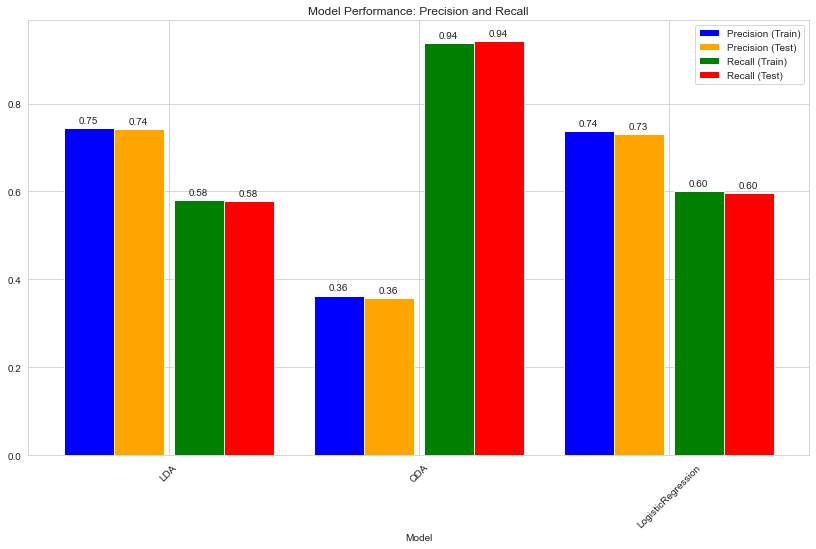

In [16]:
model_metrics = extract_precision_recall_from_cm(trained_models)
plot_precision_recall_performance(model_metrics)

In [2]:


# Assuming df is your loaded dataset
# df = pd.read_csv('your_dataset.csv')

def preprocess_data(df, dropna=True, drop_columns=[]):
    if dropna:
        df = df.dropna()
    df = pd.get_dummies(df, drop_first=True)
    df = df.drop(columns=drop_columns)
    return df

def create_pipeline(estimator, use_scaler=True):
    steps = []
    if use_scaler:
        steps.append(('scaler', MinMaxScaler()))
    steps.append(('estimator', estimator))
    pipeline = Pipeline(steps)
    return pipeline

def perform_grid_search(X_train, y_train, estimator, param_grid, cv_strategy, detailed_results_file):
    pipeline = create_pipeline(estimator)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_strategy, scoring='f1', n_jobs=-1, return_train_score=False)
    # grid_search = RandomizedSearchCV(pipeline, param_grid, cv=cv_strategy, scoring='f1', n_jobs=-1, return_train_score=False)
    grid_search.fit(X_train, y_train)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    # # Save the summary results to a CSV file
    # summary_results = results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    # summary_results.to_csv(summary_results_file, index=False)
    
    # Extract only the detailed results for the best parameter set
    columns_to_keep = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    columns_to_keep.extend([key for key in grid_search.cv_results_ if key.startswith('split')])
    results_filtered = results[columns_to_keep]
    
    results_filtered.to_csv(detailed_results_file, index=False)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions)
    return f1


param_grid_rfc = {
    'estimator__n_estimators': [100, 200, 300, 500, 1000],  # Number of trees in the forest
    'estimator__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'estimator__max_depth': [10, 20, 30, 40, 50, None],  # Maximum number of levels in tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'estimator__criterion': ['gini', 'entropy', 'log_loss'] # Method of selecting samples for training each tree
}

param_grid_lda = {
    # 'estimator__solver': ['svd', 'lsqr', 'eigen'],
    # 'estimator__n_components': [1, 2, 3, ...], # Uncomment if dimensionality reduction is needed
    # Shrinkage can only be used with the 'lsqr' and 'eigen' solvers
    'estimator__shrinkage': [None, 'auto', 0.99, 0.8, 0.6, 0.4, 0.2, 0.01]  # or a list np.linspace(0, 1, num=10)
}

param_grid_qda = {
    'estimator__reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Regularization parameter
}

param_grid_lr = [
    {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__solver': ['newton-cg', 'lbfgs', 'sag'], 'estimator__penalty': ['l2', 'none'], 'estimator__max_iter': [100, 200, 300]},
    {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__solver': ['liblinear'], 'estimator__penalty': ['l1', 'l2'], 'estimator__max_iter': [100, 200, 300]},
    {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__solver': ['saga'], 'estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'], 'estimator__max_iter': [100, 200, 300]}
]

param_grid_dtr = {
    'estimator__max_depth': [None, 10, 20, 30, 40, 50],
    'estimator__min_samples_split': [2, 5, 10, 20],
    'estimator__min_samples_leaf': [1, 2, 4, 10],
    'estimator__max_features': ['auto', 'sqrt', 'log2', None],
    'estimator__criterion': ['gini', 'entropy']
}

param_grid_knn = {
    'estimator__n_neighbors': [3, 5, 7, 10, 15],
    'estimator__weights': ['uniform', 'distance'],
    # 'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'estimator__p': [1, 2, 3]  # Typically, 1 (Manhattan) or 2 (Euclidean) are used, but you can explore others
}


# Define your estimators and their parameter grids
estimators_and_parameters = {
    'LDA': (LDA(), param_grid_lda),
    'QDA': (QDA(), param_grid_qda),
    'LR': (LogisticRegression(), param_grid_lr),
    'DTR': (DecisionTreeClassifier(), param_grid_dtr),
    'KNN': (KNeighborsClassifier(), param_grid_knn),
    # 'SVM': (SVC(), param_grid_svm),
    'RFC': (RandomForestClassifier(), param_grid_rfc)
}

df = pd.read_csv('data_preprocessed.csv')
df_processed = preprocess_data(df, drop_columns=['relationship_Wife'])

# Split dataset into training and test data
X = df_processed.drop('income_>50K', axis=1)
y = df_processed['income_>50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the cross-validation strategy
cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Search for the best model and parameters for each estimator
#best_models = {}
#best_parameters = {}
#for name, (estimator, param_grid) in estimators_and_parameters.items():
#    detailed_results_file = f'{name}_grid_search_detailed.csv'
#    best_model, best_params, best_score = perform_grid_search(
#        X_train, y_train, estimator, param_grid, cv_strategy, detailed_results_file)
#    best_models[name] = best_model
#    best_parameters[name] = best_params
#    print(f"Best F1 score for {name}: {best_score}")
#    print(f"Best parameters for {name}: {best_params}")



In [11]:

def load_and_display_top_params(model_name, scaler):
    # Construct the file name based on the provided model name
    file_name = f"{scaler}/{model_name}_grid_search_detailed.csv"
    
    # Load the data from CSV file
    results = pd.read_csv(file_name)
    
    # Drop rows with NaN values
    results.dropna(inplace=True)
    
    # Sort the results by the rank of the test scores
    results_sorted = results.sort_values(by='rank_test_score')
    
    # Extract the top three sets of parameters
    top_three_params = results_sorted.head(3)
    
    # Display the top three best sets of parameters
    print("Top three best sets of parameters:")
    for index, row in top_three_params.iterrows():
       # print(f"Rank {row['rank_test_score']}: {row['params']}, Mean Score: {row['mean_test_score']}, Std Dev: {row['std_test_score']}")
        pass
    return top_three_params

def get_cv_results_for_best_params(model_name, scaler):
    # Load the data and get the top three best parameter sets
    top_params = load_and_display_top_params(model_name, scaler)
    
    # Extract the best parameter set (the first row in the sorted dataframe)
    best_params_row = top_params.iloc[0]
    
    # Get all columns that contain individual CV results
    cv_score_columns = [col for col in best_params_row.index if col.startswith('split')]
    
    # Extract these scores
    cv_scores = best_params_row[cv_score_columns]
    
    import ast
    best_params_dict = ast.literal_eval(best_params_row['params'])
    

    return cv_scores.to_list(), best_params_dict

cv_results_min_max={}
cv_results_standard={}
best_params_min_max={}
best_params_standard={}
for name in estimators_and_parameters.keys():
    print(name)
    cv_results_min_max[name], best_params_min_max[name] = get_cv_results_for_best_params(name, scaler='MinMaxResults')
    cv_results_standard[name], best_params_standard[name] = get_cv_results_for_best_params(name, scaler='ScalerResults')
    print()


LDA
Top three best sets of parameters:
Top three best sets of parameters:

QDA
Top three best sets of parameters:
Top three best sets of parameters:

LR
Top three best sets of parameters:
Top three best sets of parameters:

DTR
Top three best sets of parameters:
Top three best sets of parameters:

KNN
Top three best sets of parameters:
Top three best sets of parameters:

RFC
Top three best sets of parameters:
Top three best sets of parameters:



In [12]:
best_params_min_max

{'LDA': {'estimator__shrinkage': None},
 'QDA': {'estimator__reg_param': 0.1},
 'LR': {'estimator__C': 100,
  'estimator__max_iter': 100,
  'estimator__penalty': 'l1',
  'estimator__solver': 'liblinear'},
 'DTR': {'estimator__criterion': 'gini',
  'estimator__max_depth': 10,
  'estimator__max_features': None,
  'estimator__min_samples_leaf': 2,
  'estimator__min_samples_split': 20},
 'KNN': {'estimator__n_neighbors': 11, 'estimator__weights': 'uniform'},
 'RFC': {'estimator__criterion': 'log_loss',
  'estimator__max_depth': None,
  'estimator__max_features': 'sqrt',
  'estimator__min_samples_leaf': 2,
  'estimator__min_samples_split': 10,
  'estimator__n_estimators': 500}}

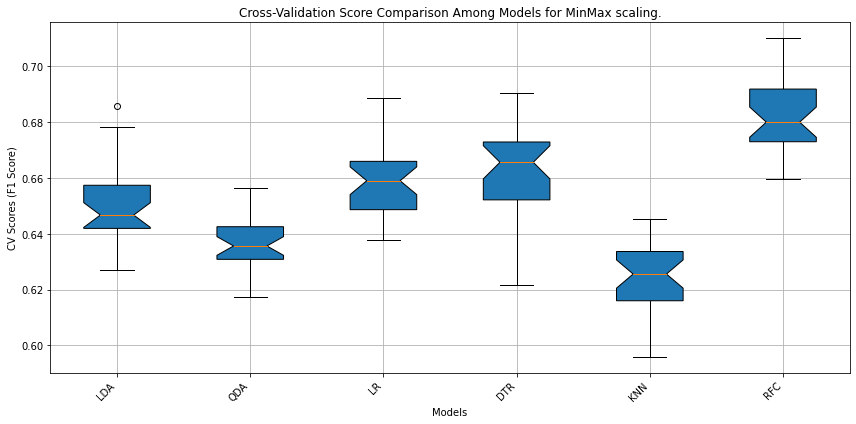

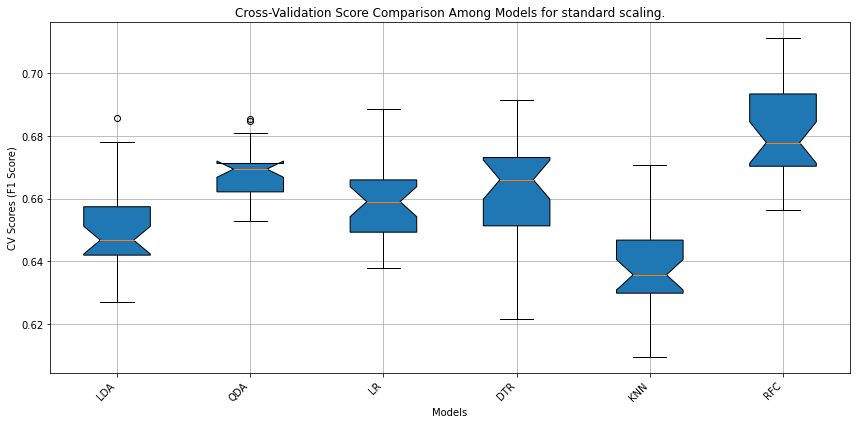

In [7]:
import matplotlib.pyplot as plt

def plot_cv_results(cv_results, scaler):
    """
    Plot boxplots for cross-validation results of multiple models.

    Parameters:
    cv_results (dict): A dictionary where keys are model names and values are lists of CV scores.
    """
    # Set up the plot
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    data = [scores for scores in cv_results.values()]
    labels = list(cv_results.keys())
    
    # Create boxplot
    plt.boxplot(data, labels=labels, notch=True, patch_artist=True)
    
    # Add title and labels
    plt.title(f'Cross-Validation Score Comparison Among Models {scaler}')
    plt.ylabel('CV Scores (F1 Score)')
    plt.xlabel('Models')
    
    # Rotate model names for better readability if there are many models
    if len(labels) > 5:
        plt.xticks(rotation=45, ha='right')
    
    # Display the plot
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()


plot_cv_results(cv_results_min_max, scaler="for MinMax scaling.")
plot_cv_results(cv_results_standard, scaler="for standard scaling.")


In [13]:
def create_model(model_name, params):
    # Remove the 'estimator__' prefix and instantiate models
    cleaned_params = {k.replace('estimator__', ''): v for k, v in params.items()}
    
    if model_name == 'LDA':
        return LDA(**cleaned_params)
    elif model_name == 'QDA':
        return QDA(**cleaned_params)
    elif model_name == 'LR':
        return LogisticRegression(**cleaned_params)
    elif model_name == 'DTR':
        return DecisionTreeClassifier(**cleaned_params)
    elif model_name == 'KNN':
        return KNeighborsClassifier(**cleaned_params)
    elif model_name == 'RFC':
        return RandomForestClassifier(**cleaned_params)
    else:
        raise ValueError("Unknown model name provided")

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(best_params, X_train, y_train, X_test, y_test):
    results = {}
    for model_name, params in best_params.items():
        # Instantiate the model with the provided parameters
        model = create_model(model_name, params)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_pred_train)
        train_precision = precision_score(y_train, y_pred_train, average='binary', zero_division=0)
        train_recall = recall_score(y_train, y_pred_train, average='binary', zero_division=0)
        train_f1 = f1_score(y_train, y_pred_train, average='binary', zero_division=0)
        
        test_accuracy = accuracy_score(y_test, y_pred_test)
        test_precision = precision_score(y_test, y_pred_test, average='binary', zero_division=0)
        test_recall = recall_score(y_test, y_pred_test, average='binary', zero_division=0)
        test_f1 = f1_score(y_test, y_pred_test, average='binary', zero_division=0)
        
        # Store in results
        results[model_name] = {
            'train': {
                'accuracy': train_accuracy,
                'precision': train_precision,
                'recall': train_recall,
                'f1': train_f1
            },
            'test': {
                'accuracy': test_accuracy,
                'precision': test_precision,
                'recall': test_recall,
                'f1': test_f1
            }
        }
    return results


In [15]:
# Assuming the function and models are correctly defined
metrics_results = calculate_metrics(best_params_standard, X_train, y_train, X_test, y_test)

c:\Users\Artur\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


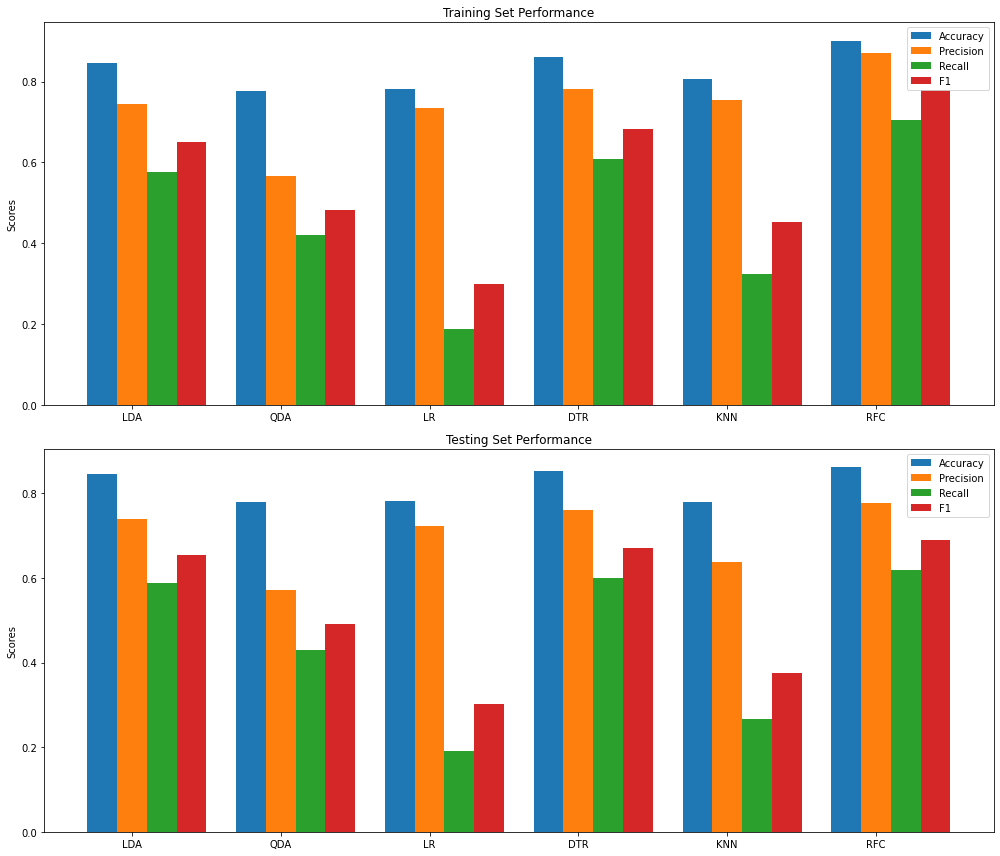

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_performance(metric_dict):
    labels = list(metric_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    train_scores = {metric: [metric_dict[model]['train'][metric] for model in labels] for metric in metrics}
    test_scores = {metric: [metric_dict[model]['test'][metric] for model in labels] for metric in metrics}

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, axs = plt.subplots(2, figsize=(14, 12))  # Create two subplots vertically

    # Plot for training set
    for i, metric in enumerate(metrics):
        axs[0].bar(x + i*width, train_scores[metric], width, label=metric.capitalize())
    axs[0].set_ylabel('Scores')
    axs[0].set_title('Training Set Performance')
    axs[0].set_xticks(x + width)
    axs[0].set_xticklabels(labels)
    axs[0].legend()

    # Plot for testing set
    for i, metric in enumerate(metrics):
        axs[1].bar(x + i*width, test_scores[metric], width, label=metric.capitalize())
    axs[1].set_ylabel('Scores')
    axs[1].set_title('Testing Set Performance')
    axs[1].set_xticks(x + width)
    axs[1].set_xticklabels(labels)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_model_performance(metrics_results)



c:\Users\Artur\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\Artur\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\Artur\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\Artur\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\Artur\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\Artur\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should on

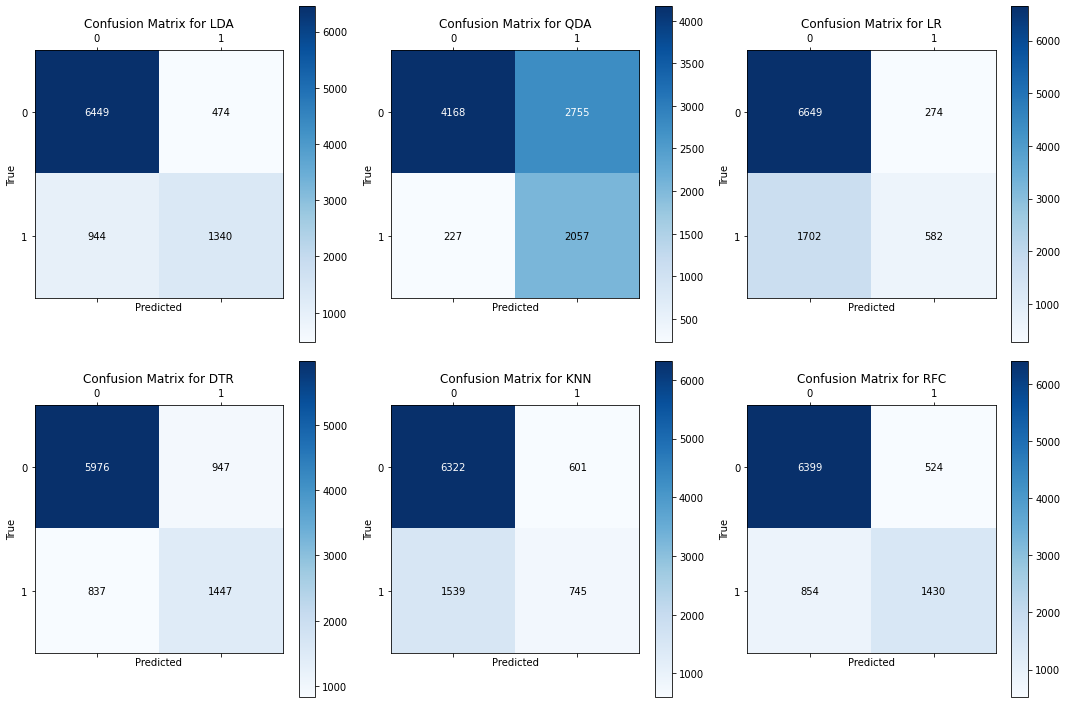

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np

def plot_confusion_matrices(best_params, models, X_test, y_test):
    """
    Plots confusion matrices for multiple models on the test dataset.
    
    Parameters:
    best_params (dict): Dictionary containing the best parameters for each model.
    models (dict): Dictionary mapping model names to their respective uninitialized model classes.
    X_test (array-like): Test set features.
    y_test (array-like): True labels for the test set.
    """
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the grid size depending on the number of models
    axes = axes.flatten()
    
    for ax, (model_name, model_class) in zip(axes, models.items()):
        # Initialize and train the model
        model = model_class(**best_params[model_name].get('estimator__', {}))
        model.fit(X_train, y_train)  # Assuming X_train and y_train are globally accessible or passed as arguments
        
        # Make predictions and compute confusion matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        labels = unique_labels(y_test, y_pred)
        
        # Plot confusion matrix
        cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Confusion Matrix for {model_name}')
        ax.set_xticklabels([''] + list(labels))
        ax.set_yticklabels([''] + list(labels))
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        
        # Annotate confusion matrix with text
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Example usage
models = {
    'LDA': LDA,
    'QDA': QDA,
    'LR': LogisticRegression,
    'DTR': DecisionTreeClassifier,
    'KNN': KNeighborsClassifier,
    'RFC': RandomForestClassifier
}

plot_confusion_matrices(best_params_standard, models, X_test, y_test)
